In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
import plotly.express as px

from pyspark.mllib.clustering import BisectingKMeans as BM
from pyspark.mllib.clustering import BisectingKMeansModel
from pyspark.ml.clustering import BisectingKMeans

In [3]:
spark = SparkSession.Builder().appName('DDAM_Project_est').getOrCreate()
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/East_Incidents_Cleaned.csv')

In [4]:
df.show()

23/12/11 12:17:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|         Start_Time|         Start_Lat|         Start_Lng|Distance_mi|     City|   County|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-------

In [5]:
df_cluster=df
df_cluster.count()

394519

In [6]:
df_kmodes=df

In [6]:
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','hour','month']
df_cluster=df_cluster.drop(*to_drop) # con asterisco passo gli elementi singoli al metodo drop
df_cluster.show()

+--------+------------------+------------------+-----------+-----+-------------+-------------+-------------+--------------+----------------+-----------------+---------------+------+---------------+---------------------+
|Severity|         Start_Lat|         Start_Lng|Distance_mi|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Weather_Condition|day_of_the_week|season|Working_Weekend|Astronomical_Twilight|
+--------+------------------+------------------+-----------+-----+-------------+-------------+-------------+--------------+----------------+-----------------+---------------+------+---------------+---------------------+
|       2|         33.032551|        -81.346909|        0.0|   SC|         30.0|         93.0|         10.0|           0.0|             0.0|           Normal|         Monday|Spring|     WorkingDay|                  Day|
|       2|         33.023018|        -81.274361|      0.129|   SC|         73.0|         47.0|         10.0|           6

Normalization

In [7]:
col = ['Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in','Start_Lat','Start_Lng']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData = output_dataset.select("features_scaled", "Severity")

clusteringData.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features_scaled                                                                                                                                  |Severity|
+-------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[0.0,0.2111111111111111,0.9292929292929294,0.5,0.0,0.0,0.0720299466298682,0.24107333358026017]                                                   |2       |
|[0.0011425737137188562,0.45,0.4646464646464647,0.5,0.05714285714285715,0.0,0.07129086345738816,0.24697906156168675]                              |2       |
|[0.001080573589718608,0.5,0.14141414141414144,0.5,0.06666666666666668,0.0,0.07135521245908323,0.24220412240131434]                               |2       |
|[0.0,0.3,1.0,0.0125,0.0,0.0,0.07628426846000383,0.2523332

K-Means with k in range[2-30]

************************************************



23/12/03 17:19:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=36416Kb max_used=36466Kb free=94655Kb
 bounds [0x00000001069d8000, 0x0000000108db8000, 0x000000010e9d8000]
 total_blobs=13837 nmethods=12700 adapters=1049
 compilation: disabled (not enough contiguous free space left)


Results for K = 2
Silhouette with squared euclidean distance: 0.5263
SSE (Sum of Squared Errors): 41923.20353014611
************************************************

Results for K = 3
Silhouette with squared euclidean distance: 0.4540
SSE (Sum of Squared Errors): 33945.18514090311
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.4434
SSE (Sum of Squared Errors): 26621.215962076876
************************************************

Results for K = 5
Silhouette with squared euclidean distance: 0.3667
SSE (Sum of Squared Errors): 25293.983174209887
************************************************



Results for K = 6
Silhouette with squared euclidean distance: 0.3776
SSE (Sum of Squared Errors): 22452.76751177171
************************************************



Results for K = 7
Silhouette with squared euclidean distance: 0.4314
SSE (Sum of Squared Errors): 19108.582300571117
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.4036
SSE (Sum of Squared Errors): 17842.867496009043
************************************************



Results for K = 9
Silhouette with squared euclidean distance: 0.4250
SSE (Sum of Squared Errors): 16682.888256380462
************************************************

Results for K = 10
Silhouette with squared euclidean distance: 0.4193
SSE (Sum of Squared Errors): 17220.981223471616
************************************************

Results for K = 11
Silhouette with squared euclidean distance: 0.4029
SSE (Sum of Squared Errors): 14674.562017850805
************************************************

Results for K = 12
Silhouette with squared euclidean distance: 0.3900
SSE (Sum of Squared Errors): 13977.737630299982
************************************************

Results for K = 13
Silhouette with squared euclidean distance: 0.3733
SSE (Sum of Squared Errors): 13566.365785359625
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.3692
SSE (Sum of Squared Errors): 13082.064925230554
************************************************



Results for K = 15
Silhouette with squared euclidean distance: 0.3552
SSE (Sum of Squared Errors): 12738.492494778797
************************************************



Results for K = 16
Silhouette with squared euclidean distance: 0.3628
SSE (Sum of Squared Errors): 12230.995529702888
************************************************

Results for K = 17
Silhouette with squared euclidean distance: 0.3814
SSE (Sum of Squared Errors): 11735.12926789008
************************************************

Results for K = 18
Silhouette with squared euclidean distance: 0.3405
SSE (Sum of Squared Errors): 11780.027784218964
************************************************

Results for K = 19
Silhouette with squared euclidean distance: 0.3607
SSE (Sum of Squared Errors): 11495.216536502885
************************************************

Results for K = 20
Silhouette with squared euclidean distance: 0.3550
SSE (Sum of Squared Errors): 10812.963440543685
************************************************



Results for K = 21
Silhouette with squared euclidean distance: 0.3470
SSE (Sum of Squared Errors): 10629.714833129518
************************************************



Results for K = 22
Silhouette with squared euclidean distance: 0.3441
SSE (Sum of Squared Errors): 10575.56081202542
************************************************



Results for K = 23
Silhouette with squared euclidean distance: 0.3439
SSE (Sum of Squared Errors): 10230.389378973665
************************************************



Results for K = 24
Silhouette with squared euclidean distance: 0.3544
SSE (Sum of Squared Errors): 10016.343541263454
************************************************



Results for K = 25
Silhouette with squared euclidean distance: 0.3567
SSE (Sum of Squared Errors): 9756.989079119578
************************************************



Results for K = 26
Silhouette with squared euclidean distance: 0.3336
SSE (Sum of Squared Errors): 9696.50308050005
************************************************



Results for K = 27
Silhouette with squared euclidean distance: 0.3335
SSE (Sum of Squared Errors): 9566.666293208686
************************************************



Results for K = 28
Silhouette with squared euclidean distance: 0.3330
SSE (Sum of Squared Errors): 9376.545168830706
************************************************



Results for K = 29
Silhouette with squared euclidean distance: 0.3542
SSE (Sum of Squared Errors): 9055.135017098502


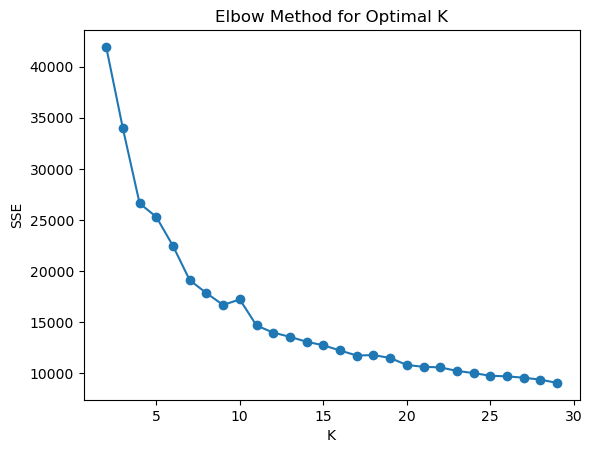

Elbow detected at K = 8


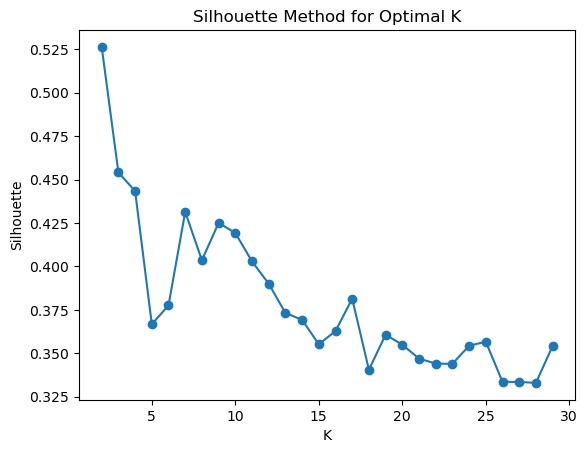

In [7]:
!pip install kneed
!pip install yellowbrick
from kneed import KneeLocator
import matplotlib.pyplot as plt


sse_values = []
silhouette_values = []
for k in range(2,30):

    print('************************************************\n')
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(clusteringData)
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()


Facendo un tradeoff tra silhouette e SSE si puo dire che il k ideale per i nostri dati è compreso tra [6-9]

K-Means(K=7) with respect to Severity

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117
Contingency Table:
severity       1      2     3     4
prediction                         
0            622  14171   562   588
1           3511  61793  2329  1881
2            367  67865  3070  1357
3           2286  66381  2575  4080
4           5195  58060  2075  2453
5            324  25211  1150  1177
6            357  58577  2401  4101


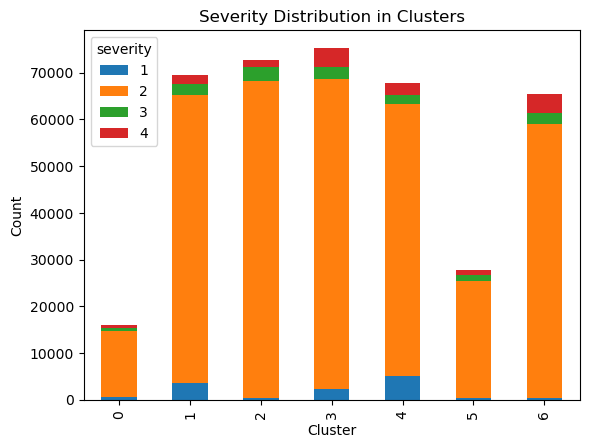

In [12]:
df_cluster_severity=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_cluster_severity=df_cluster_severity.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_severity)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_severity = output_dataset.select("features_scaled", "Severity")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_severity)
predictions = model.transform(clusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=7) with respect to State

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117
Contingency Table:
state            NC       NY       PA       SC       VA
prediction                                             
0            6195.0      NaN      NaN   8111.0   1637.0
1           31801.0      NaN      NaN  35013.0   2700.0
2               NaN  54329.0  18330.0      NaN      NaN
3             138.0  17039.0  26180.0      NaN  31965.0
4           25471.0      NaN      NaN  38440.0   3872.0
5              12.0   9865.0  11510.0      NaN   6475.0
6             596.0   1399.0  16563.0      NaN  46878.0


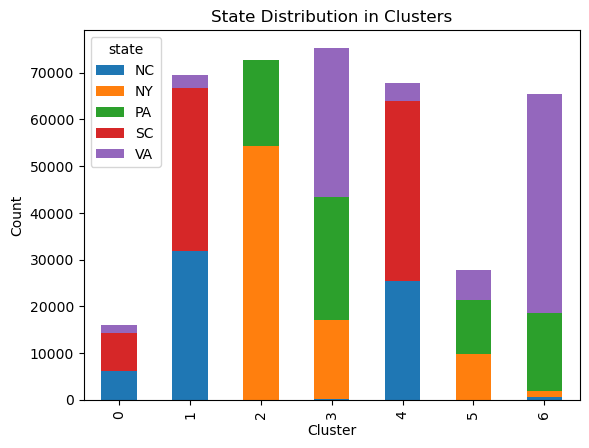

In [13]:
df_cluster_state=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_cluster_state=df_cluster_state.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_state)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_state = output_dataset.select("features_scaled", "State")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_state)
predictions = model.transform(clusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=5) with respect to Astronomical Twilight

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117
Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      12482   3461
1                      64950   4564
2                      64403   8256
3                      57162  18160
4                      51325  16458
5                      22651   5211
6                      60147   5289


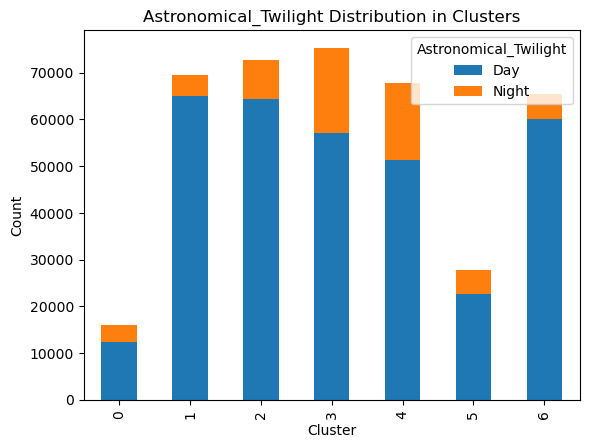

In [14]:
df_cluster_day=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_day=df_cluster_day.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_day)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_day = output_dataset.select("features_scaled", "Astronomical_Twilight")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_day)
predictions = model.transform(clusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=5) with respect to Weather_Condition

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117
Contingency Table:
Weather_Condition  Cloudy  Foggy  Normal   Rain  Snow
prediction                                           
0                    3194   2841    1065   7623  1220
1                   27212     68   41713    516     5
2                   33324     56   38205    917   157
3                   36211    253   29573   8160  1125
4                   33670    203   29487   4311   112
5                    3062   3690     891  12161  8058
6                   25638    164   38722    664   248


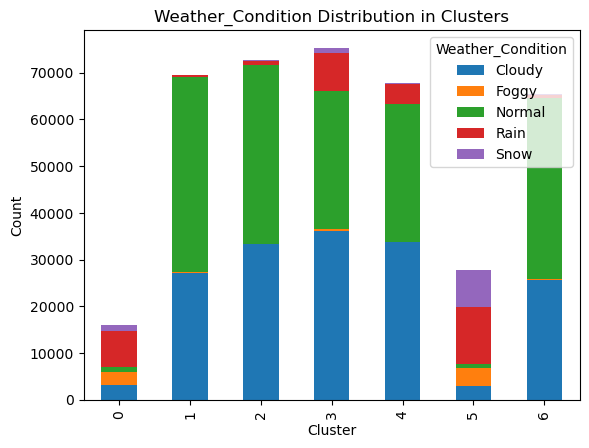

In [15]:
df_cluster_condition=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_condition=df_cluster_condition.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_condition)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_condition = output_dataset.select("features_scaled", "Weather_Condition")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_condition)
predictions = model.transform(clusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=7) with respect to day_of_the_week

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117
Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                  2671    2100      1369    1612      3583     2166   
1                 13234   10246      7033    5258     10912    11926   
2                 12219    9397      9722    8267     10563    10911   
3                 11111   10686      8135    7124     13715    11948   
4                 10965    9891      7203    5933     11862    10458   
5                  5208    3389      3122    2942      6261     3761   
6                 11967    9204      8652    6277      9303     9491   

day_of_the_week  Wednesday  
prediction                  
0                     2442  
1                    10905  
2                    11580  
3                    12603  
4                    11471  
5                     3179  
6                    10542  


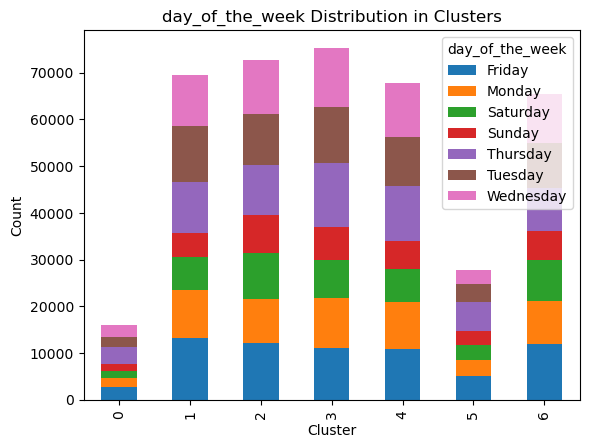

In [16]:
df_cluster_dayweek=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_dayweek=df_cluster_dayweek.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_dayweek)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_dayweek = output_dataset.select("features_scaled", "day_of_the_week")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_dayweek)
predictions = model.transform(clusteringData_dayweek)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=7) with respect to season

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117
Contingency Table:
Season      Autumn  Spring  Summer  Winter
prediction                                
0             2676    3406    2411    7450
1            14079   23027   15241   17167
2            17662   16444   26376   12177
3            20063   15620   21229   18410
4            13354   16562   21077   16790
5             5358    7196    2962   12346
6            14617   17761   16336   16722


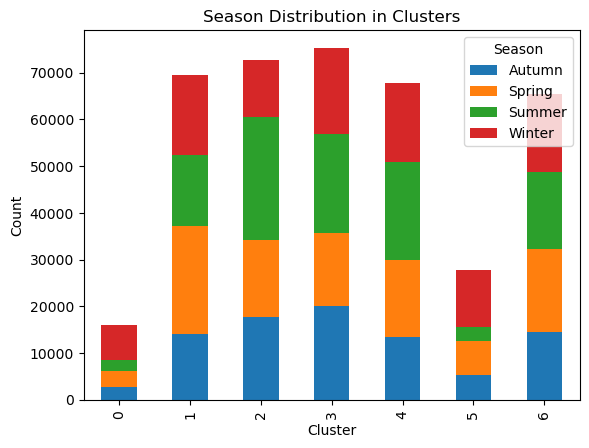

In [17]:
df_cluster_season=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_season=df_cluster_season.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_season)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_season = output_dataset.select("features_scaled", "season")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_season)
predictions = model.transform(clusteringData_season)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


K-Means(K=7) with respect to Working_Weekend

Silhouette  = 0.4313819750974456

SSE  = 19108.582300571117


Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                   2981       12962
1                  12291       57223
2                  17989       54670
3                  15259       60063
4                  13136       54647
5                   6064       21798
6                  14929       50507


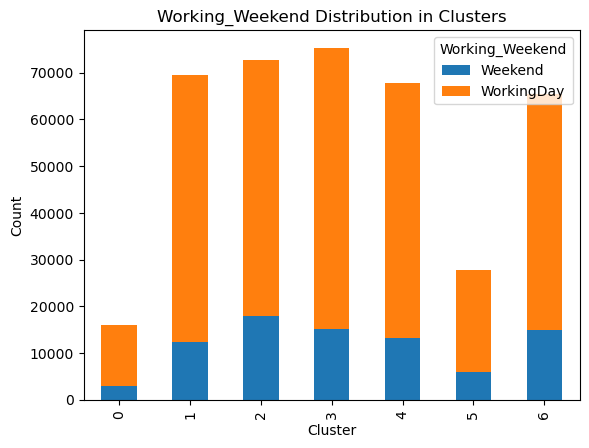

In [18]:
df_cluster_working=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_cluster_working=df_cluster_working.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_working)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
clusteringData_working = output_dataset.select("features_scaled", "Working_Weekend")

kmeans = KMeans(featuresCol="features_scaled").setK(7)
model = kmeans.fit(clusteringData_working)
predictions = model.transform(clusteringData_working)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means with k in range(2,30)

+-------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features_scaled                                                                                                                                  |Severity|
+-------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[0.0720299466298682,0.24107333358026017,0.0,0.2111111111111111,0.9292929292929294,0.5,0.0,0.0]                                                   |2       |
|[0.07129086345738816,0.24697906156168675,0.0011425737137188562,0.45,0.4646464646464647,0.5,0.05714285714285715,0.0]                              |2       |
|[0.07135521245908323,0.24220412240131434,0.001080573589718608,0.5,0.14141414141414144,0.5,0.06666666666666668,0.0]                               |2       |
|[0.07628426846000383,0.25233327458647503,0.0,0.3,1.0,0.01

Results for K = 2
Silhouette with squared euclidean distance: 0.5263
SSE (Sum of Squared Errors): 41923.20206040572
************************************************

Results for K = 3
Silhouette with squared euclidean distance: 0.4634
SSE (Sum of Squared Errors): 33220.29474967142
************************************************



Results for K = 4
Silhouette with squared euclidean distance: 0.4431
SSE (Sum of Squared Errors): 26635.177440856773
************************************************

Results for K = 5
Silhouette with squared euclidean distance: 0.3988
SSE (Sum of Squared Errors): 23735.862845578187
************************************************

Results for K = 6
Silhouette with squared euclidean distance: 0.4254
SSE (Sum of Squared Errors): 20889.948112657148
************************************************

Results for K = 7
Silhouette with squared euclidean distance: 0.3600
SSE (Sum of Squared Errors): 19957.484269908713
************************************************



Results for K = 8
Silhouette with squared euclidean distance: 0.3550
SSE (Sum of Squared Errors): 19126.417556241206
************************************************

Results for K = 9
Silhouette with squared euclidean distance: 0.3076
SSE (Sum of Squared Errors): 18331.72235927303
************************************************

Results for K = 10
Silhouette with squared euclidean distance: 0.2801
SSE (Sum of Squared Errors): 17674.91106659916
************************************************

Results for K = 11
Silhouette with squared euclidean distance: 0.2544
SSE (Sum of Squared Errors): 17066.640424189332
************************************************

Results for K = 12
Silhouette with squared euclidean distance: 0.2669
SSE (Sum of Squared Errors): 15942.402130661887
************************************************



Results for K = 13
Silhouette with squared euclidean distance: 0.3105
SSE (Sum of Squared Errors): 14524.530206656875
************************************************



Results for K = 14
Silhouette with squared euclidean distance: 0.3037
SSE (Sum of Squared Errors): 14030.336929507816
************************************************

Results for K = 15
Silhouette with squared euclidean distance: 0.3014
SSE (Sum of Squared Errors): 13699.24773627554
************************************************

Results for K = 16
Silhouette with squared euclidean distance: 0.2886
SSE (Sum of Squared Errors): 13399.13400420973
************************************************

Results for K = 17
Silhouette with squared euclidean distance: 0.2949
SSE (Sum of Squared Errors): 12854.606903085261
************************************************

Results for K = 18
Silhouette with squared euclidean distance: 0.2851
SSE (Sum of Squared Errors): 12552.115478715326
************************************************



Results for K = 19
Silhouette with squared euclidean distance: 0.2780
SSE (Sum of Squared Errors): 12162.931015037666
************************************************

Results for K = 20
Silhouette with squared euclidean distance: 0.2774
SSE (Sum of Squared Errors): 11764.527854754044
************************************************



Results for K = 21
Silhouette with squared euclidean distance: 0.2824
SSE (Sum of Squared Errors): 11483.457437773988
************************************************



Results for K = 22
Silhouette with squared euclidean distance: 0.2823
SSE (Sum of Squared Errors): 11232.614703332005
************************************************



Results for K = 23
Silhouette with squared euclidean distance: 0.2856
SSE (Sum of Squared Errors): 11014.889806327901
************************************************



Results for K = 24
Silhouette with squared euclidean distance: 0.2822
SSE (Sum of Squared Errors): 10823.094283665405
************************************************



Results for K = 25
Silhouette with squared euclidean distance: 0.2804
SSE (Sum of Squared Errors): 10679.317672846686
************************************************



Results for K = 26
Silhouette with squared euclidean distance: 0.2802
SSE (Sum of Squared Errors): 10545.589887193652
************************************************



Results for K = 27
Silhouette with squared euclidean distance: 0.2794
SSE (Sum of Squared Errors): 10319.619775769654
************************************************



Results for K = 28
Silhouette with squared euclidean distance: 0.2779
SSE (Sum of Squared Errors): 10199.828294586381
************************************************



Results for K = 29
Silhouette with squared euclidean distance: 0.2816
SSE (Sum of Squared Errors): 9996.355115519696


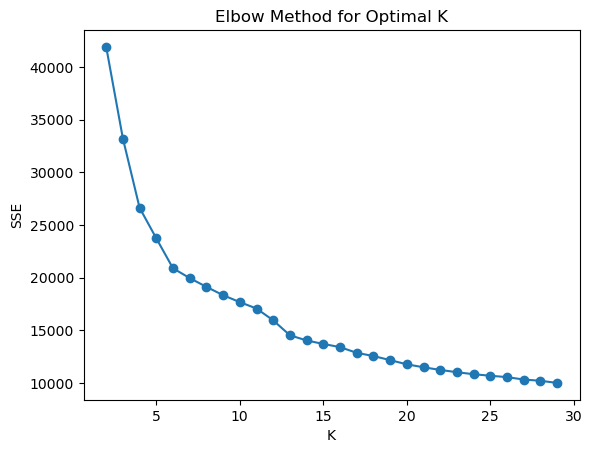

Elbow detected at K = 6


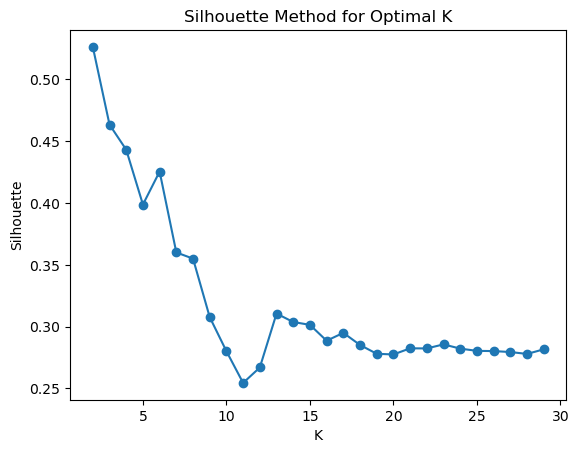

In [19]:
df_cluster_bisecting=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_cluster_bisecting=df_cluster_bisecting.drop(*to_drop) # con asterisco passo gli elementi singoli al metodo drop


col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_cluster_bisecting)

scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

output_dataset = scaler.fit(output_dataset).transform(output_dataset)

clusteringData_bisecting = output_dataset.select("features_scaled", "Severity")

clusteringData_bisecting.show(truncate=False)



!pip install kneed
from kneed import KneeLocator
import matplotlib.pyplot as plt


sse_values = []
silhouette_values = []
for k in range(2,30):

    print('************************************************\n')

    bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=k)
    model = bisect_kmeans.fit(clusteringData_bisecting)
    
    evaluator = ClusteringEvaluator(featuresCol="features_scaled")
    predictions = model.transform(clusteringData_bisecting)
    silhouette = evaluator.evaluate(predictions)
    sse = model.summary.trainingCost
    
    print(f"Results for K = {k}")
    print(f"Silhouette with squared euclidean distance: {silhouette:.4f}")
    print(f"SSE (Sum of Squared Errors): {sse}")
    sse_values.append(sse)
    silhouette_values.append(silhouette)

# Plot SSE per valutare l'elbow
plt.figure()
plt.plot(range(2, 30), sse_values, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 30), sse_values, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

plt.figure()
plt.plot(range(2, 30), silhouette_values, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.title("Silhouette Method for Optimal K")
plt.show()

In linea generale i risultati con questo algoritmo sono più scarsi per qualsiasi valore di K,
Facendo un tradeoff tra silhouette e SSE si puo dire che il k ideale per i nostri dati è k=6

Bisecting K-Means(K=6) with respect to Severity

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
severity       1      2     3     4
prediction                         
0           3900  69718  2626  2610
1           5440  67280  2458  3003
2            381  57396  2346  3546
3            364  65174  2970  1311
4            324  25320  1162  1200
5           2253  67170  2600  3967


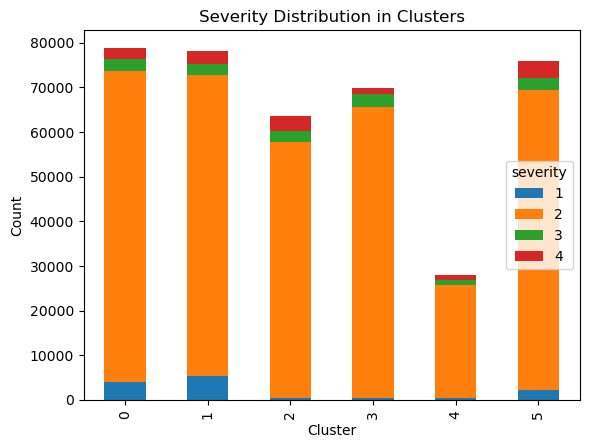

In [21]:
df_clusterbisecting_severity=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_clusterbisecting_severity=df_clusterbisecting_severity.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_severity)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_severity = output_dataset.select("features_scaled", "Severity")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_severity)
predictions = model.transform(bisectingclusteringData_severity)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'severity').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=6) with respect to State

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
state            NC       NY       PA       SC       VA
prediction                                             
0           35082.0      NaN      NaN  38502.0   5270.0
1           28978.0      NaN      NaN  43062.0   6141.0
2              82.0   1586.0  17610.0      NaN  44391.0
3               NaN  50206.0  19613.0      NaN      NaN
4              16.0   9728.0  11550.0      NaN   6712.0
5              55.0  21112.0  23810.0      NaN  31013.0


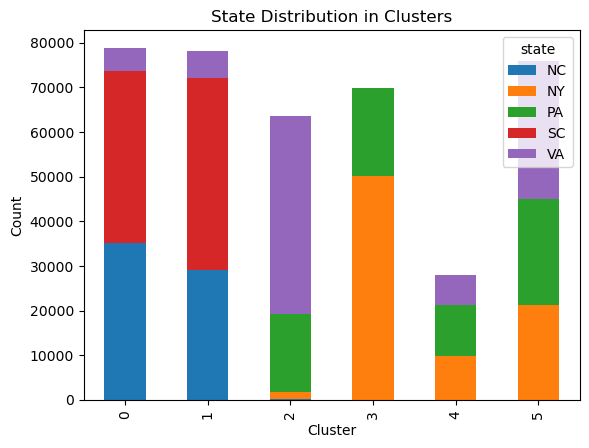

In [25]:
df_clusterbisecting_state=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Astronomical_Twilight']
df_clusterbisecting_state=df_clusterbisecting_state.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_state)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_state= output_dataset.select("features_scaled", "State")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_state)
predictions = model.transform(bisectingclusteringData_state)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'state').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='state', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=6) with respect to Astronomical_Twilight

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
Astronomical_Twilight    Day  Night
prediction                         
0                      73064   5790
1                      58773  19408
2                      58664   5005
3                      62200   7619
4                      22748   5258
5                      57671  18319


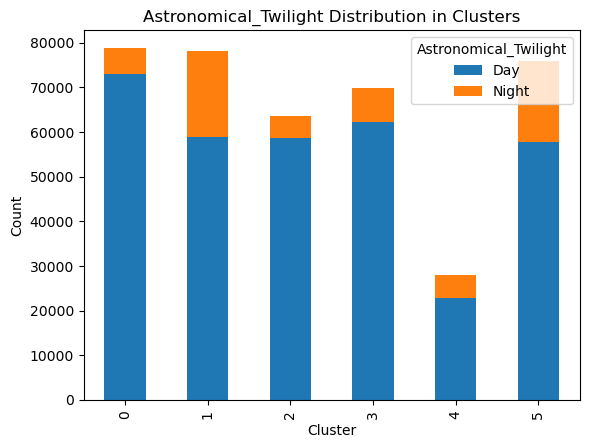

In [26]:
df_clusterbisecting_day=df
to_drop=['Start_Time','City','County','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_day=df_clusterbisecting_day.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_day)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_day= output_dataset.select("features_scaled", "Astronomical_Twilight")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_day)
predictions = model.transform(bisectingclusteringData_day)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=6) with respect to Weather_Condition

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
Weather_Condition  Cloudy  Foggy  Normal   Rain  Snow
prediction                                           
0                   31500     95   46549    704     6
1                   33952   3012   28078  11815  1324
2                   25281    121   37386    648   233
3                   31374     36   37629    672   108
4                    3052   3750     921  12213  8070
5                   37152    261   29093   8300  1184


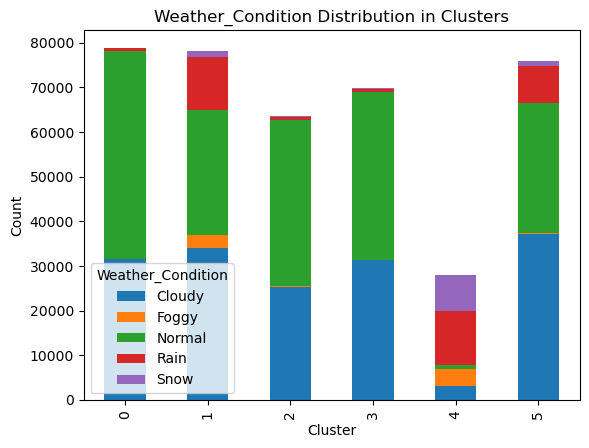

In [28]:
df_clusterbisecting_condition=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_condition=df_clusterbisecting_condition.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_condition)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_condition= output_dataset.select("features_scaled", "Weather_Condition")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_condition)
predictions = model.transform(bisectingclusteringData_condition)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=6) with respect to day_of_the_week

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
prediction                                                             
0                 14920   11440      8221    6202     12355    13293   
1                 12577   11302      7916    7100     14526    11684   
2                 11625    8948      8446    6006      9130     9315   
3                 11864    8945      9492    7854     10011    10530   
4                  5239    3392      3150    2959      6294     3805   
5                 11150   10886      8011    7292     13883    12034   

day_of_the_week  Wednesday  
prediction                  
0                    12423  
1                    13076  
2                    10199  
3                    11123  
4                     3167  
5                    12734  


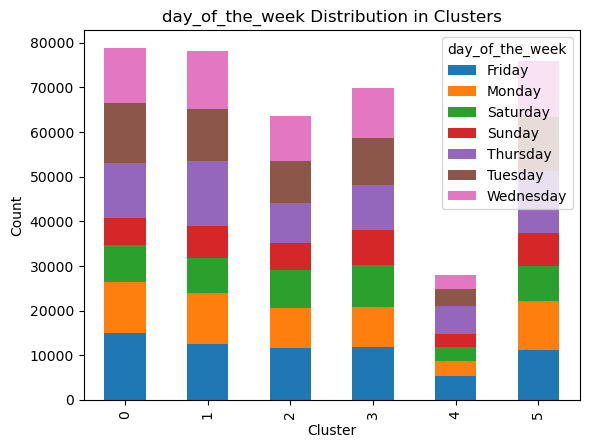

In [29]:
df_clusterbisecting_dayweek=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_dayweek=df_clusterbisecting_dayweek.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_dayweek)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_dayweek= output_dataset.select("features_scaled", "day_of_the_week")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_dayweek)
predictions = model.transform(bisectingclusteringData_dayweek)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='day_of_the_week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=6) with respect to season

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
season      Autumn  Spring  Summer  Winter
prediction                                
0            16031   25329   18121   19373
1            14987   18649   21587   22958
2            14191   17165   16154   16159
3            16704   15658   25376   12081
4             5354    7249    2993   12410
5            20542   15966   21401   18081


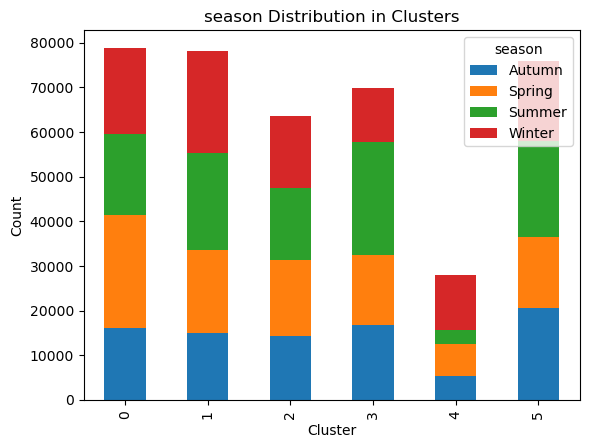

In [30]:
df_clusterbisecting_season=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_season=df_clusterbisecting_season.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_season)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_season= output_dataset.select("features_scaled", "season")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_season)
predictions = model.transform(bisectingclusteringData_season)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Bisecting K-Means(K=6) with respect to Working_Weekend

Silhouette  = 0.4254435554251372

SSE  = 20889.948112657148
Contingency Table:
Working_Weekend  Weekend  WorkingDay
prediction                          
0                  14423       64431
1                  15016       63165
2                  14452       49217
3                  17346       52473
4                   6109       21897
5                  15303       60687


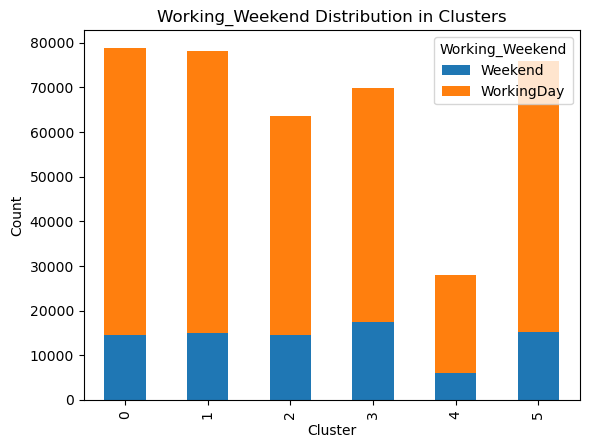

In [31]:
df_clusterbisecting_working=df
to_drop=['Start_Time','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
df_clusterbisecting_working=df_clusterbisecting_working.drop(*to_drop)

col = ['Start_Lat','Start_Lng','Distance_mi','Temperature_F','Humidity_perc','Visibility_mi','Wind_Speed_mph','Precipitation_in']

assembler = VectorAssembler(
    inputCols=col,
    outputCol="features")

output_dataset = assembler.transform(df_clusterbisecting_working)
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
bisectingclusteringData_working= output_dataset.select("features_scaled", "Working_Weekend")

bisect_kmeans=BisectingKMeans(featuresCol="features_scaled",k=6)
model = bisect_kmeans.fit(bisectingclusteringData_working)
predictions = model.transform(bisectingclusteringData_working)

evaluator = ClusteringEvaluator(featuresCol="features_scaled")
silhouette = evaluator.evaluate(predictions)
sse = model.summary.trainingCost
print("Silhouette  = " + str(silhouette))
print("\nSSE  = " + str(sse))

centers = model.clusterCenters()
contingency_table = predictions.groupBy('prediction', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='prediction', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


# K-Modes

In [8]:
!pip install .
from pyspark_kmodes import *
from kneed import KneeLocator

Processing /Users/diabelny/Desktop/DDAM Project/Project/DDAM-Project/pyspark-distributed-kmodes-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark-kmodes: filename=pyspark_kmodes-0.1.0-py2.py3-none-any.whl size=12669 sha256=315de60c456765ce104654b1b7ab5801f1a4a58dc0c570b1bdf527e616c83f65
  Stored in directory: /Users/diabelny/Library/Caches/pip/wheels/a5/4d/9b/9c410473d87e10d3856898d8c41d8acb8c931f0200a065e241
Successfully built pyspark-kmodes


In [19]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_row_id = df.withColumn("row_id", monotonically_increasing_id())
df_kmodes_id= df_with_row_id.select('row_id','City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','hour','month','season','Weather_Condition','Astronomical_Twilight','Severity', 'Working_Weekend','State','day_of_the_week')

In [9]:
df_kmodes=df.select('City','County','Wind_Direction','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout',
                     'Station','Stop','Traffic_Calming','Traffic_Signal','hour','month','season','Weather_Condition','Astronomical_Twilight',
                     'Severity')
df_kmodes.show()

+---------+---------+--------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+----+-----+------+-----------------+---------------------+--------+
|     City|   County|Wind_Direction|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|hour|month|season|Weather_Condition|Astronomical_Twilight|Severity|
+---------+---------+--------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+----+-----+------+-----------------+---------------------+--------+
|Allendale|Allendale|          CALM|  false|false|   false|   false|   false|  false|  false|     false|  false| true|          false|         false|   6|    3|Spring|           Normal|                  Day|       2|
|Allendale|Allendale|             E|  false|false|   false|   false|   false|  false|  false|     false|  false| true|          fals

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 57.0
Run 1, iteration: 2/100, moves: 0, cost: 57.0
Avg cost/partition: 3.5625
Final centroids:
['Richmond' 'Wake' 'CALM' False False False False False False False False
 False False False False 16 4 'Spring' 'Normal' 'Day']
['Bronx' 'Queens' 'CALM' False False False False False False False False
 False False False False 7 8 'Summer' 'Cloudy' 'Day']


Iteration  0


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


Iteration  1
CodeCache: size=131072Kb used=29953Kb max_used=29964Kb free=101118Kb
 bounds [0x00000001089d8000, 0x000000010a758000, 0x00000001109d8000]
 total_blobs=11517 nmethods=10570 adapters=858
 compilation: disabled (not enough contiguous free space left)


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 95.0
Run 1, iteration: 2/100, moves: 0, cost: 95.0
Avg cost/partition: 3.9583333333333335
Final centroids:
['Richmond' 'Greenville' 'CALM' False False False False False False False
 False False False False False 16 12 'Spring' 'Cloudy' 'Day']
['Brooklyn' 'Kings' 'VAR' False False False False False False False False
 False False False False 14 6 'Summer' 'Normal' 'Day']
['Columbia' 'Richland' 'CALM' False False False False False False False
 False False False False False 17 9 'Autumn' 'Normal' 'Day']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3, cost: 115.0
Run 1, iteration: 2/100, moves: 0, cost: 115.0
Avg cost/partition: 3.59375
Final centroids:
['Richmond' 'Fairfax County' 'CALM' False False False False False False
 False False False False False False 17 12 'Winter' 'Normal' 'Day']
['Philadelphia' 'Philadelphia' 'CALM' False False False False False False
 False False False False False False 15 4 'Spring' 'Cloudy' 'Day']
['Myrtle Beach' 'Horry' 'SW' False False False False False False False
 False False False False False 14 5 'Spring' 'Normal' 'Day']
['Charlotte' 'Mecklenburg' 'CALM' False False False False False False
 False False False False False False 16 8 'Summer' 'Cloudy' 'Day']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7, cost: 141.0
Run 1, iteration: 2/100, moves: 0, cost: 141.0
Avg cost/partition: 3.525
Final centroids:
['Charlotte' 'Mecklenburg' 'CALM' False False False False False False
 False False False False False False 17 12 'Winter' 'Normal' 'Day']
['Greenville' 'Greenville' 'CALM' False False False False False False
 False False False False False False 15 9 'Autumn' 'Normal' 'Day']
['Philadelphia' 'Philadelphia' 'W' False False True False False False
 False False False False False True 16 4 'Spring' 'Cloudy' 'Day']
['Spartanburg' 'Spartanburg' 'CALM' False False False False False False
 False False False False False False 7 4 'Spring' 'Normal' 'Day']
['Bronx' 'Queens' 'CALM' False False False False False False False False
 False False False False 15 8 'Summer' 'Cloudy' 'Day']


Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 184.0
Run 1, iteration: 2/100, moves: 0, cost: 184.0
Avg cost/partition: 3.8333333333333335
Final centroids:
['Richmond' 'Fairfax County' 'CALM' False False False False False False
 False False False False False False 15 12 'Winter' 'Normal' 'Day']
['Bronx' 'Queens' 'S' False False False False False False False False
 False False False False 15 5 'Spring' 'Cloudy' 'Day']
['Richmond' 'Richmond City' 'CALM' False False True False False False
 False False False False False True 17 12 'Winter' 'Cloudy' 'Day']
['Columbia' 'Richland' 'CALM' False False False False False False False
 False False False False False 16 8 'Summer' 'Cloudy' 'Day']
['Greenville' 'Greenville' 'WSW' False False True False False False False
 False False False False True 8 2 'Winter' 'Normal' 'Day']
['New York' 'New York' 'VAR' False False True False False False False
 False False False False True 14

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 206.0
Run 1, iteration: 2/100, moves: 0, cost: 206.0
Avg cost/partition: 3.6785714285714284
Final centroids:
['Richmond' 'Fairfax County' 'CALM' False False False False False False
 False False False False False False 17 12 'Winter' 'Normal' 'Day']
['Brooklyn' 'Kings' 'VAR' False False True False False False False False
 False False False True 14 6 'Summer' 'Normal' 'Day']
['Charlotte' 'Mecklenburg' 'SW' False False False False False False False
 False False False False False 16 5 'Spring' 'Cloudy' 'Day']
['Rochester' 'Monroe' 'CALM' False False False False False False False
 False False False False False 15 8 'Summer' 'Cloudy' 'Day']
['Richmond' 'Prince William' 'CALM' False False False False False False
 False False False False False False 8 3 'Spring' 'Cloudy' 'Day']
['Spartanburg' 'Spartanburg' 'CALM' False False False False False False
 False False False False F

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10, cost: 239.0
Run 1, iteration: 2/100, moves: 1, cost: 239.0
Avg cost/partition: 3.734375
Final centroids:
['Raleigh' 'Wake' 'CALM' False False False False False False False False
 False False False False 16 4 'Spring' 'Normal' 'Day']
['Philadelphia' 'Philadelphia' 'E' False False True False False False
 False False False False False True 22 2 'Winter' 'Cloudy' 'Night']
['Charlotte' 'Mecklenburg' 'N' False False False False False False False
 False False False False False 15 9 'Autumn' 'Cloudy' 'Day']
['Rochester' 'Monroe' 'NNW' False False False False False False False
 False False False False False 7 1 'Winter' 'Snow' 'Day']
['Brooklyn' 'Kings' 'CALM' False False False False False False False False
 False False False False 7 9 'Autumn' 'Normal' 'Day']
['New York' 'New York' 'VAR' True False True False False False False False
 False False False True 16 7 'Summer' 'Normal' 

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8, cost: 247.0
Run 1, iteration: 2/100, moves: 3, cost: 246.0
Run 1, iteration: 3/100, moves: 0, cost: 246.0
Avg cost/partition: 3.4166666666666665
Final centroids:
['Raleigh' 'Wake' 'CALM' False False False False False False False False
 False False False False 16 9 'Autumn' 'Normal' 'Day']
['Charlotte' 'Mecklenburg' 'SW' False False False False False False False
 False False False False False 16 6 'Summer' 'Cloudy' 'Day']
['Philadelphia' 'Philadelphia' 'SW' False False False False False False
 False False False False False False 15 4 'Spring' 'Cloudy' 'Day']
['Conway' 'Horry' 'CALM' False False False False False False False False
 False False False False 19 12 'Winter' 'Normal' 'Day']
['Summerville' 'Horry' 'CALM' False False False False False False False
 False False False False False 22 4 'Spring' 'Normal' 'Night']
['Richmond' 'Norfolk' 'CALM' False False False False Fals

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8, cost: 274.0
Run 1, iteration: 2/100, moves: 3, cost: 274.0
Avg cost/partition: 3.425
Final centroids:
['Columbia' 'Richland' 'CALM' False False False False False False False
 False False False False False 15 7 'Summer' 'Normal' 'Day']
['Norfolk' 'Norfolk' 'W' False False False False False False False False
 False False False False 7 1 'Winter' 'Cloudy' 'Day']
['Charleston' 'Charleston' 'S' False False False False False False False
 False False False False False 15 9 'Autumn' 'Cloudy' 'Day']
['Anderson' 'Montgomery' 'CALM' False False False False False False False
 False False False False False 19 12 'Winter' 'Cloudy' 'Night']
['Richmond' 'Richmond City' 'CALM' False False False False False False
 False False False False False False 7 4 'Spring' 'Cloudy' 'Day']
['Brooklyn' 'Kings' 'VAR' False False True False False False False False
 False False False True 14 6 'Summer' 'No

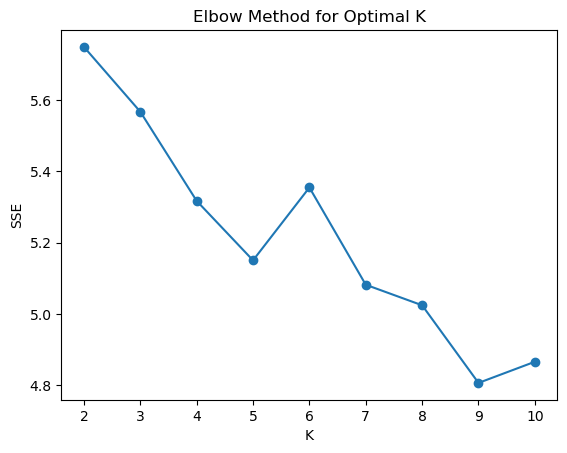

Elbow detected at K = 5


In [10]:

df_kmodes_severity=df_kmodes.drop('Severity')
df_kmodes_rdd=df_kmodes_severity.rdd

lista_costi=[]
for k in range(2,11):
    n_clusters = k
    max_iter = 10
    method = EnsembleKModes(n_clusters, max_iter)
    model = method.fit(df_kmodes_rdd)
    lista_costi.append(method.mean_cost)

plt.figure()
plt.plot(range(2, 11), lista_costi, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Trova l'elbow con KneeLocator
kl = KneeLocator(range(2, 11), lista_costi, curve="convex", direction="decreasing")
print(f"Elbow detected at K = {kl.elbow}")

In [11]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

Severity

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 150.0
Run 1, iteration: 2/100, moves: 2, cost: 150.0
Avg cost/partition: 3.75
Final centroids:
['Charlotte' 'Mecklenburg' 'CALM' False False False False False False
 False False False False False False 16 12 'Winter' 'Cloudy' 'Day']
['Greenville' 'Greenville' 'CALM' False False False False False False
 False False False False False False 14 5 'Spring' 'Normal' 'Day']
['Richmond' 'Chesterfield' 'CALM' False False False False False False
 False False False False False False 17 11 'Autumn' 'Normal' 'Day']
['Raleigh' 'Wake' 'CALM' False False True False False False False False
 False False False True 17 12 'Winter' 'Normal' 'Day']
['New York' 'Westchester' 'CALM' False False False False False False False
 False False False False False 15 8 'Summer' 'Normal' 'Day']


Contingency Table:
Severity        1       2     3     4
predictions                          
0            3652  149875  6578  6637
1            3390   67953  3722  2973
2             638   62149   531  2728
3            1149   16520   291   520
4            3833   55561  3040  2779


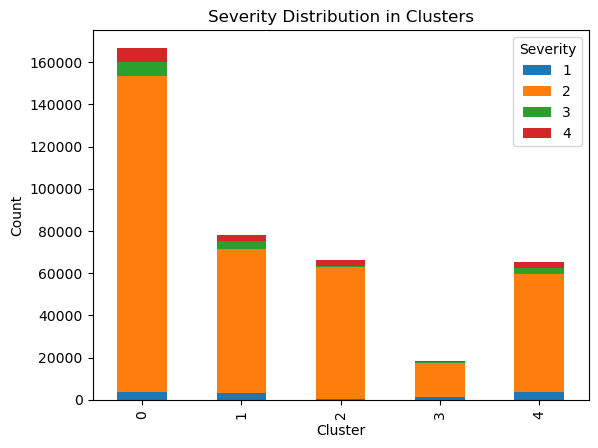

In [13]:
n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'Severity').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Severity', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Severity Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


State

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Iteration  4


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3, cost: 147.0
Run 1, iteration: 2/100, moves: 1, cost: 147.0
Avg cost/partition: 3.675
Final centroids:
['Richmond' 'Greenville' 'CALM' False False False False False False False
 False False False False False 15 12 'Winter' 'Normal' 'Day' 2]
['New York' 'New York' 'VAR' False False True False False False False
 False False False False True 14 6 'Summer' 'Cloudy' 'Day' 2]
['Charlotte' 'Mecklenburg' 'CALM' False False False False False False
 False False False False False False 16 7 'Summer' 'Cloudy' 'Day' 2]
['Philadelphia' 'Philadelphia' 'W' False False False False False False
 False False False False False False 15 4 'Spring' 'Cloudy' 'Day' 2]
['Lexington' 'Lexington' 'CALM' False False False False False False False
 False False False False False 16 5 'Spring' 'Cloudy' 'Day' 2]


Contingency Table:
State           NC     NY     PA     SC     VA
predictions                                   
0            22609  32439  37850  44282  49395
1             4375   9496   3217   2185   3777
2            26677  23846  13652  16504  20769
3             6636   9502  13034   9697  12530
4             3916   7349   4830   8896   7056


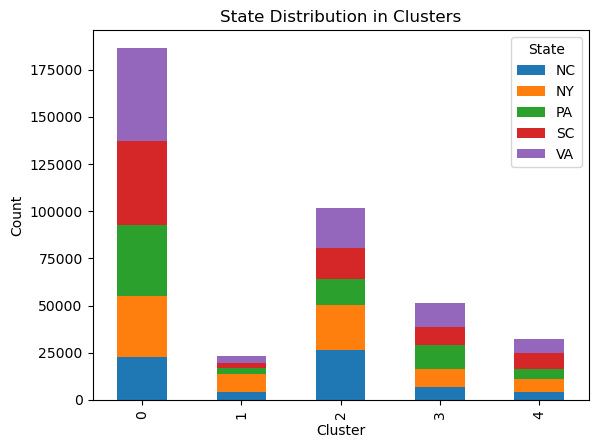

In [17]:
df_kmodes_state=df_kmodes.drop('State')
df_kmodes_rdd=df_kmodes_state.rdd


n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'State').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='State', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='State Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Astronomical_Twilight

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 149.0
Run 1, iteration: 2/100, moves: 0, cost: 149.0
Avg cost/partition: 3.725
Final centroids:
['Richmond' 'Fairfax County' 'CALM' False False False False False False
 False False False False False False 17 12 'Winter' 'Normal' 2]
['Bronx' 'Queens' 'S' False False False False False False False False
 False False False False 8 8 'Summer' 'Cloudy' 2]
['Richmond' 'Richmond City' 'CALM' False False True False False False
 False False False False False True 17 10 'Autumn' 'Cloudy' 2]
['Charleston' 'Charleston' 'SW' False False False False False False False
 False False False False False 7 3 'Spring' 'Cloudy' 2]
['Columbia' 'Richland' 'CALM' False False False False False False False
 False False False False False 16 4 'Spring' 'Normal' 2]


Contingency Table:
Astronomical_Twilight     Day  Night
predictions                         
0                      136818  36330
1                       91187  10698
2                       15897   2915
3                       46918   5783
4                       42300   5673


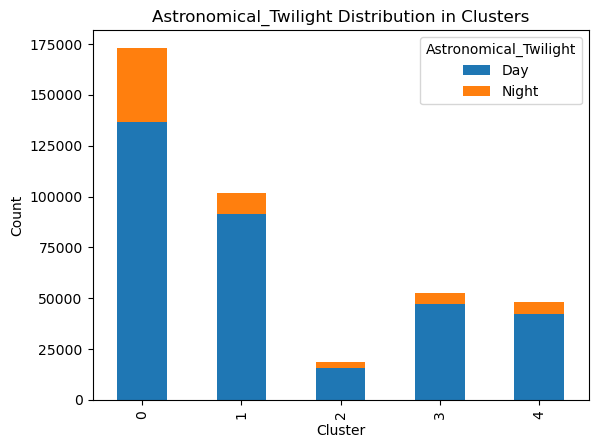

In [20]:
df_kmodes_astr=df_kmodes.drop('Astronomical_Twilight')
df_kmodes_rdd=df_kmodes_astr.rdd

n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'Astronomical_Twilight').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Astronomical_Twilight', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Astronomical_Twilight Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Weather_Condition

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 130.0
Run 1, iteration: 2/100, moves: 0, cost: 130.0
Avg cost/partition: 3.25
Final centroids:
['Greenville' 'Greenville' 'CALM' False False False False False False
 False False False False False False 17 12 'Winter' 'Day' 2]
['New York' 'New York' 'VAR' False False True False False False False
 False False False False True 14 7 'Summer' 'Day' 2]
['Charlotte' 'Mecklenburg' 'CALM' False False False False False False
 False False False False False False 16 8 'Summer' 'Day' 2]
['Brooklyn' 'Kings' 'VAR' False False False False False False False False
 False False False False 7 9 'Autumn' 'Day' 2]
['Philadelphia' 'Philadelphia' 'CALM' False False False False False False
 False False False False False False 7 4 'Spring' 'Day' 2]


Contingency Table:
Weather_Condition  Cloudy  Foggy  Normal   Rain  Snow
predictions                                          
0                   42120   3091   55862  11067  8391
1                   11470    226   10630   1747   107
2                   51200   1214   45037   7639   163
3                   26325    922   33861   6908   553
4                   31196   1822   34266   6991  1711


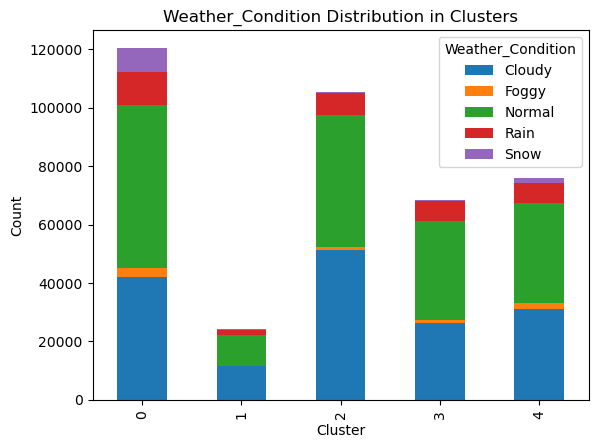

In [21]:
df_kmodes_weather=df_kmodes.drop('Weather_Condition')
df_kmodes_rdd=df_kmodes_weather.rdd

n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'Weather_Condition').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Weather_Condition', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Weather_Condition Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Day_off_the_week

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 151.0
Run 1, iteration: 2/100, moves: 0, cost: 151.0
Avg cost/partition: 3.775
Final centroids:
['Richmond' 'Richland' 'CALM' False False False False False False False
 False False False False False 15 12 'Winter' 'Normal' 'Day' 2]
['Charlotte' 'Mecklenburg' 'CALM' False False True False False False False
 False False False False True 17 8 'Summer' 'Cloudy' 'Day' 2]
['Bronx' 'Queens' 'S' False False False False False False False False
 False False False False 14 9 'Autumn' 'Cloudy' 'Day' 2]
['Charlotte' 'Mecklenburg' 'N' False False False False False False False
 False False False False False 21 1 'Winter' 'Snow' 'Night' 2]
['Spartanburg' 'Spartanburg' 'CALM' False False False False False False
 False False False False False False 16 4 'Spring' 'Cloudy' 'Day' 2]


Contingency Table:
day_of_the_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
predictions                                                            
0                 31001   25626     20616   16603     30038    28421   
1                  6075    5554      3317    2772      6685     6794   
2                 14370   11329     10304    9116     14848    13026   
3                  3269    3014      2833    3403      2612     1903   
4                 12660    9390      8166    5519     12016    10517   

day_of_the_week  Wednesday  
predictions                 
0                    29485  
1                     6700  
2                    12647  
3                     2139  
4                    11751  


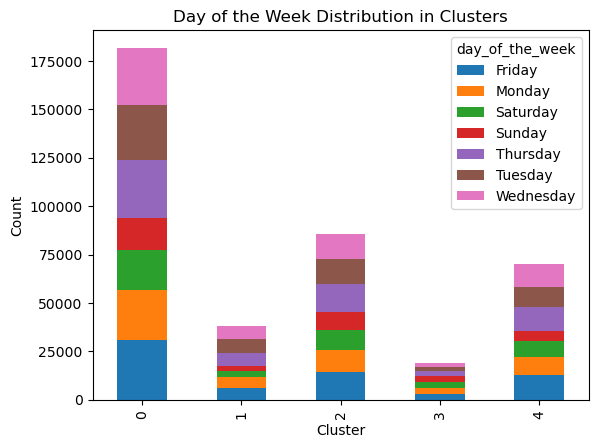

In [22]:
df_kmodes_week=df_kmodes.drop('day_of_the_week')
df_kmodes_rdd=df_kmodes_week.rdd

n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'day_of_the_week').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='day_of_the_week', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Day of the Week Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Season

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1, cost: 147.0
Run 1, iteration: 2/100, moves: 0, cost: 147.0
Avg cost/partition: 3.675
Final centroids:
['Greenville' 'Greenville' 'CALM' False False False False False False
 False False False False False False 17 12 'Normal' 'Day' 2]
['Bronx' 'Bronx' 'S' False False True False False False False False False
 False False True 11 5 'Cloudy' 'Day' 2]
['Norfolk' 'Fairfax' 'S' False False False False True False False False
 False False False False 13 11 'Cloudy' 'Day' 2]
['Greenville' 'Queens' 'SSW' False False False False False False False
 False False False False False 15 8 'Cloudy' 'Day' 2]
['Gaffney' 'Cherokee' 'SW' False False False False False False False False
 False False False False 13 1 'Rain' 'Day' 2]


Contingency Table:
season       Autumn  Spring  Summer  Winter
predictions                                
0             51241   53314   50377   70497
1              5610   10253    7446    4543
2             11140    7339    6935    4738
3             14619   23173   37619   12498
4              5199    5937    3255    8786


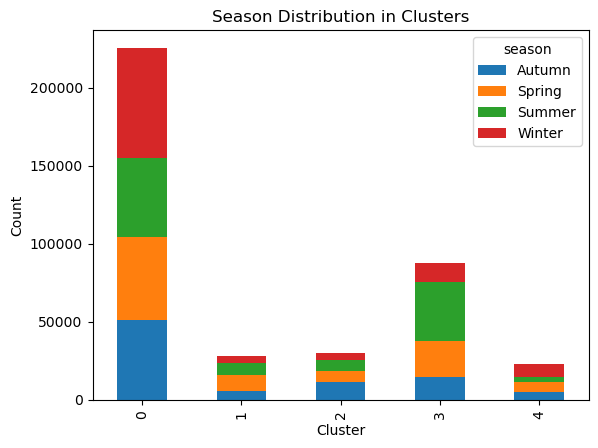

In [23]:
df_kmodes_season=df_kmodes.drop('season')
df_kmodes_rdd=df_kmodes_season.rdd

n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'season').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='season', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Season Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

Working_Weekend

Iteration  0


Iteration  1


Iteration  2


Iteration  3


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 151.0
Run 1, iteration: 2/100, moves: 0, cost: 151.0
Avg cost/partition: 3.775
Final centroids:
['Richmond' 'Richland' 'CALM' False False False False False False False
 False False False False False 17 12 'Winter' 'Normal' 'Day' 2]
['Philadelphia' 'Philadelphia' 'CALM' False False False False False False
 False False False False False False 6 4 'Summer' 'Cloudy' 'Day' 2]
['Bronx' 'Queens' 'S' False False False False False False False False
 False False False False 15 6 'Summer' 'Cloudy' 'Day' 2]
['Charlotte' 'Mecklenburg' 'SSW' False False False False False False False
 False False False False False 17 7 'Summer' 'Cloudy' 'Day' 2]
['Pittsburgh' 'Allegheny' 'NW' False False True False False False False
 False False False False True 20 12 'Winter' 'Cloudy' 'Night' 2]


Contingency Table:
Working_Weekend  Weekend  WorkingDay
predictions                         
0                  43577      162188
1                  15403       60443
2                  12523       44695
3                   8954       38143
4                   2192        6401


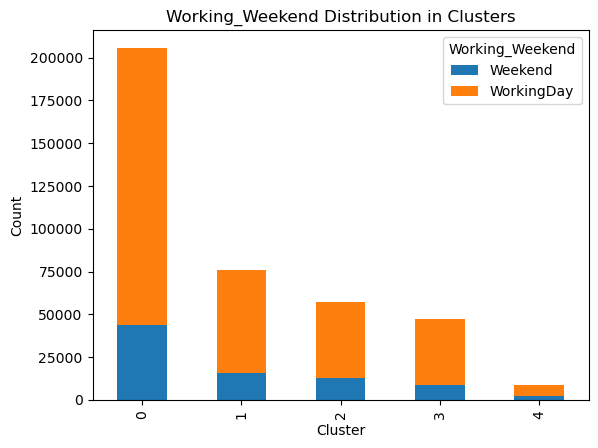

In [24]:
df_kmodes_working=df_kmodes.drop('day_of_the_week')
df_kmodes_rdd=df_kmodes_working.rdd

n_clusters = 5
max_iter = 10
method = EnsembleKModes(n_clusters, max_iter)
model = method.fit(df_kmodes_rdd)
predictions=model.predict(df_kmodes_rdd)
schema = StructType([
    StructField("predictions", IntegerType(), True)
])
df_predictions = spark.createDataFrame(predictions.map(lambda x: (int(x),)), schema)
df_predictions_id = df_predictions.withColumn("row_id", monotonically_increasing_id())
joint=df_kmodes_id.join(df_predictions_id, 'row_id')

contingency_table = joint.groupBy('predictions', 'Working_Weekend').count().toPandas()
pivot_table = contingency_table.pivot(index='predictions', columns='Working_Weekend', values='count')


print("Contingency Table:")
print(pivot_table)


pivot_table.plot(kind='bar', stacked=True, title='Working_Weekend Distribution in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()